# Setup

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from utils.functions import *
from nltk.corpus import stopwords
from tqdm import tqdm
import re
import nltk
from nltk import word_tokenize
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import streamlit as st
import keras_tuner as kt

In [5]:
df = pd.read_csv('../data/data.csv', index_col=0)

# Preprocessing

In [6]:
# nltk stopwords
stopwords = stopwords.words('english')

In [8]:
# Step 1: Lowercasing
df['title'] = df['title'].str.lower()

# Step 2: Removing Punctuation, Numbers, and Special Characters
df['title'] = df['title'].apply(lambda x: re.sub(r'\d+', '', x))
df['title'] = df['title'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

# Step 3: Tokenization
df['title'] = df['title'].apply(nltk.word_tokenize)

# Step 4: Removing Stop Words (for French title)
df['title'] = df['title'].apply(
    lambda x: [word for word in x if word not in stopwords])
# Step 5: Stemming (using SnowballStemmer for French)
#stemmer = SnowballStemmer('english')
#df['title'] = df['title'].apply(lambda x: [stemmer.stem(word) for word in x])

# Step 6: Convert tokenized words back to strings
df['title'] = df['title'].apply(' '.join)

In [9]:
# add the var length
df['length'] = df['title'].apply(lambda x: len(x.split()))

# EDA

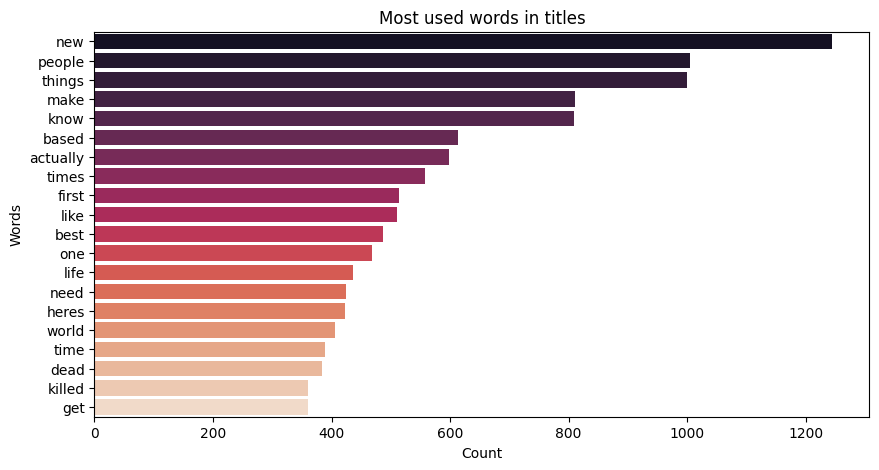

In [8]:
plot_most_used_words(df)

In [98]:
def plot_wordcloud(df, max_words = 200, max_font_size = 40):

    plt.figure(figsize=(20, 20))
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        scale=3,
        random_state=1).generate(str(df['title']))
    plt.imshow(wordcloud)
    plt.axis('off')

In [ ]:
# full data
plot_wordcloud(df)

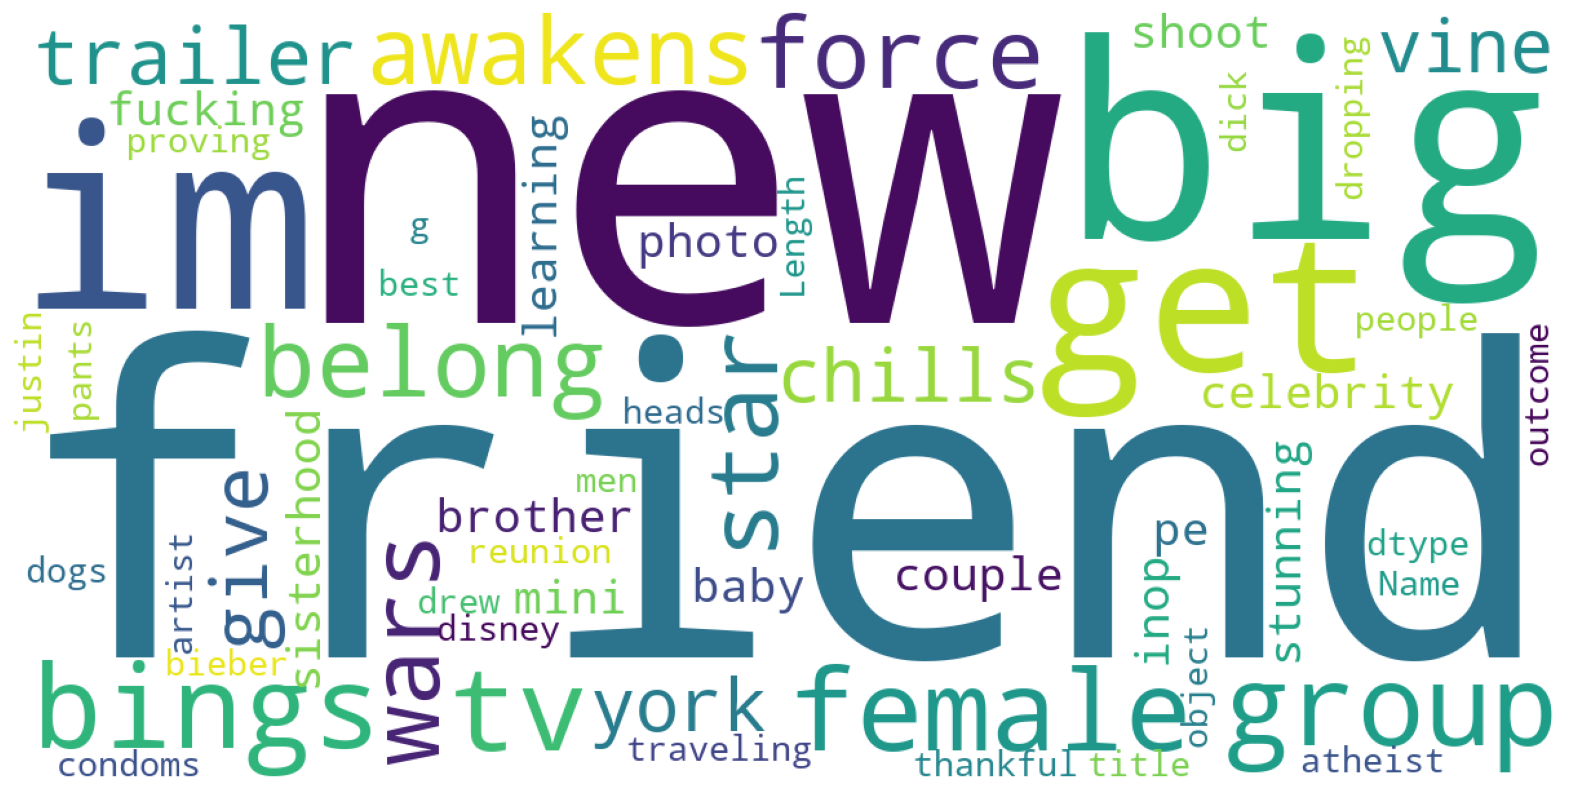

In [12]:
# positive data
plot_wordcloud(df[df['label'] == 1])

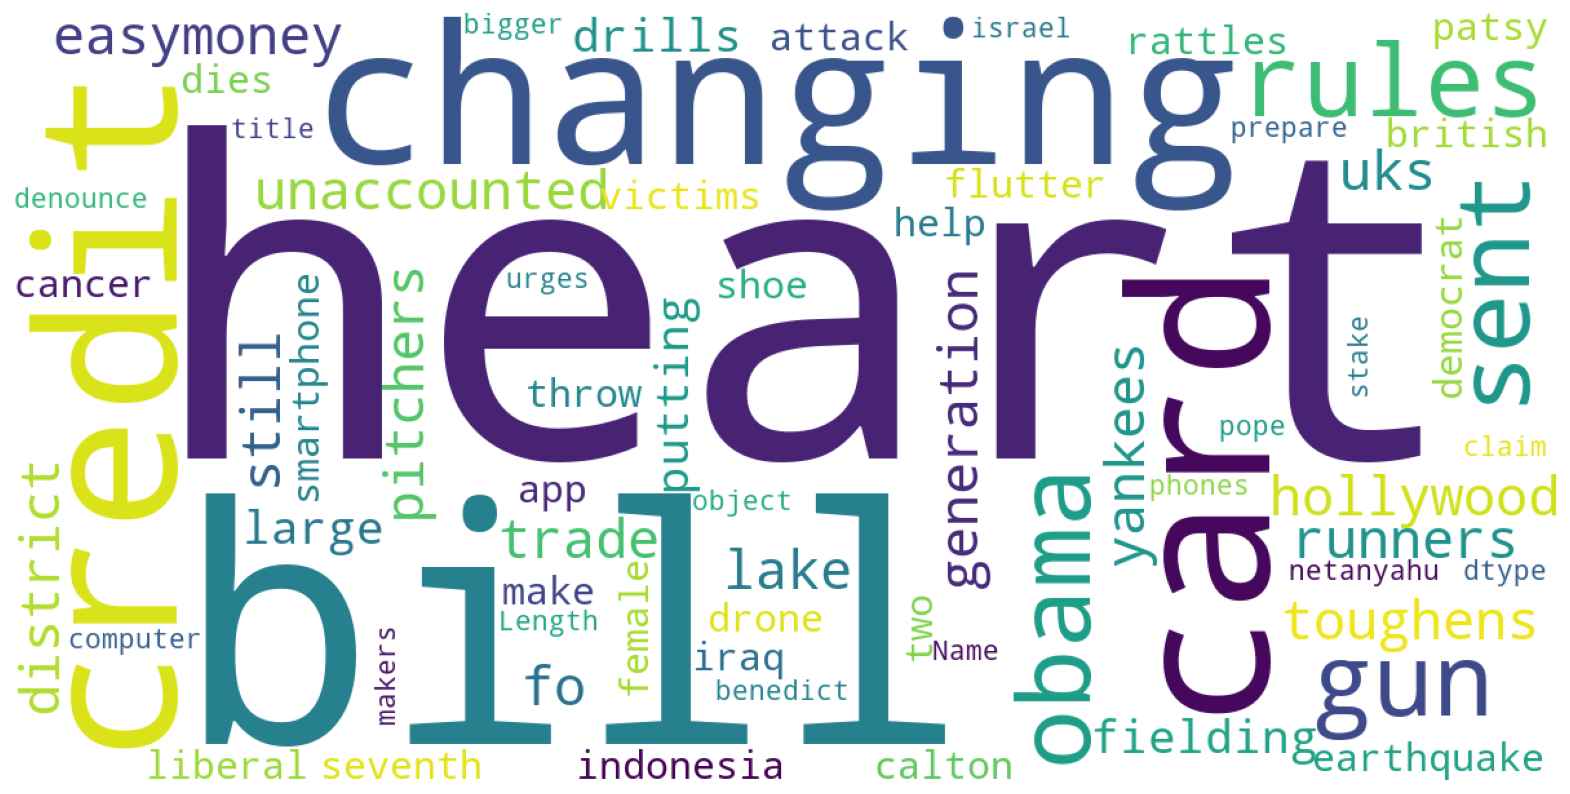

In [14]:
# negative data
plot_wordcloud(df[df['label'] == 0])

c:\Users\ISSAM ECH-CHAOUI\anaconda3\envs\envgpu\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


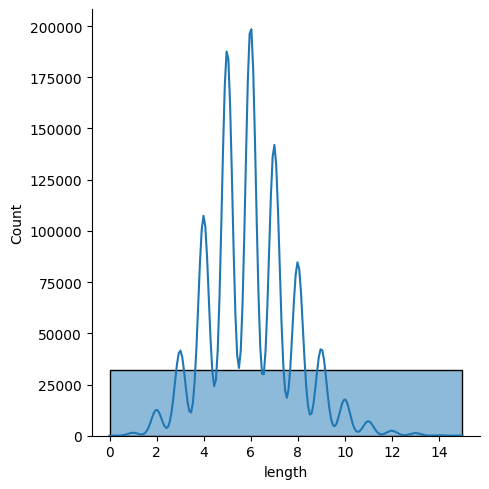

In [8]:
# write the code of plot the distribution of the length of the title with seaborn

def plot_distribution_length(df):
    import seaborn as sns
    sns.displot(df['length'], kde=True, bins=True)
    plt.show()

plot_distribution_length(df)

In [13]:
import pandas as pd
from utils.functions import *
df = pd.read_csv('../data/data.csv')

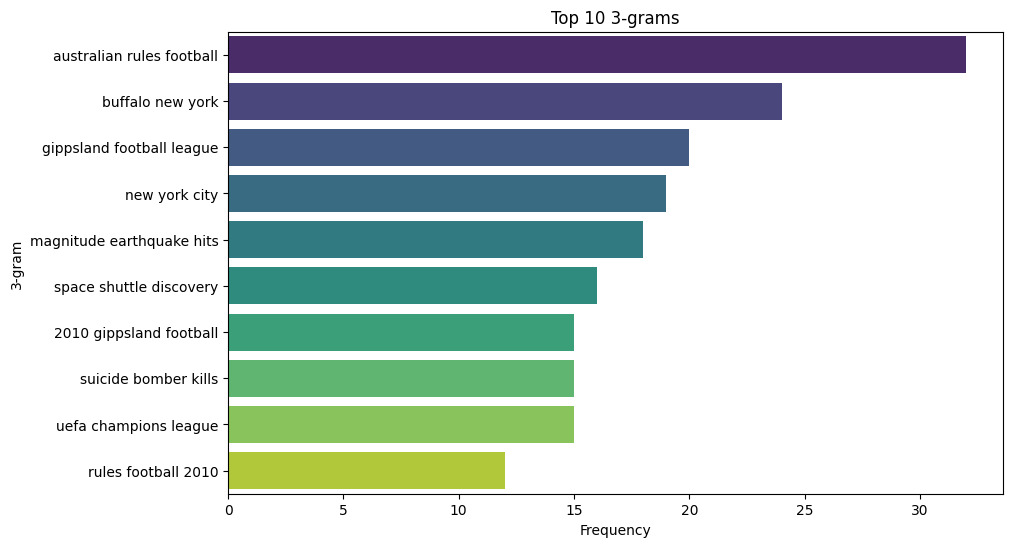

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
plot_most_frequent_ngrams(df[df['label'] == 0],n=3, num_ngrams=10)

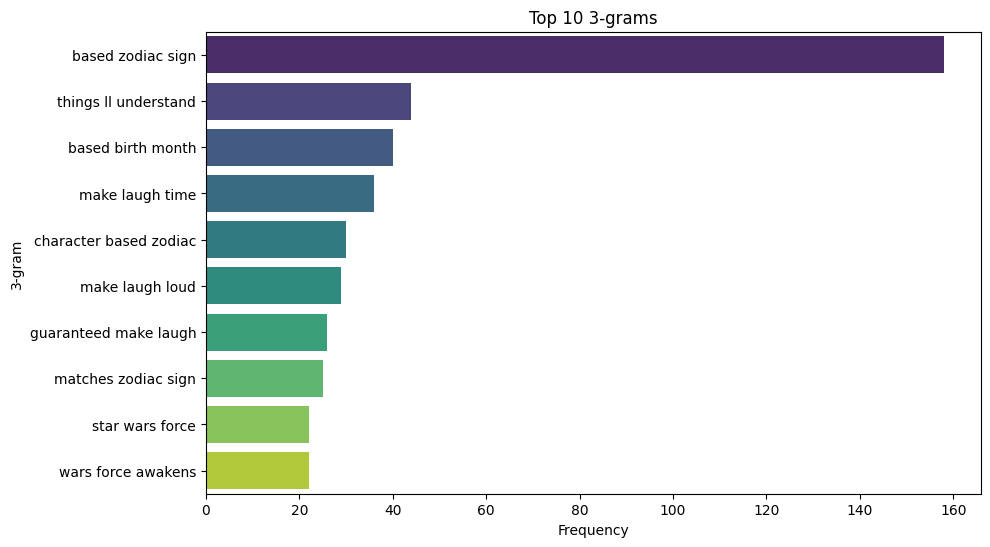

In [15]:
plot_most_frequent_ngrams(df[df['label'] == 1],  n=3, num_ngrams=10)

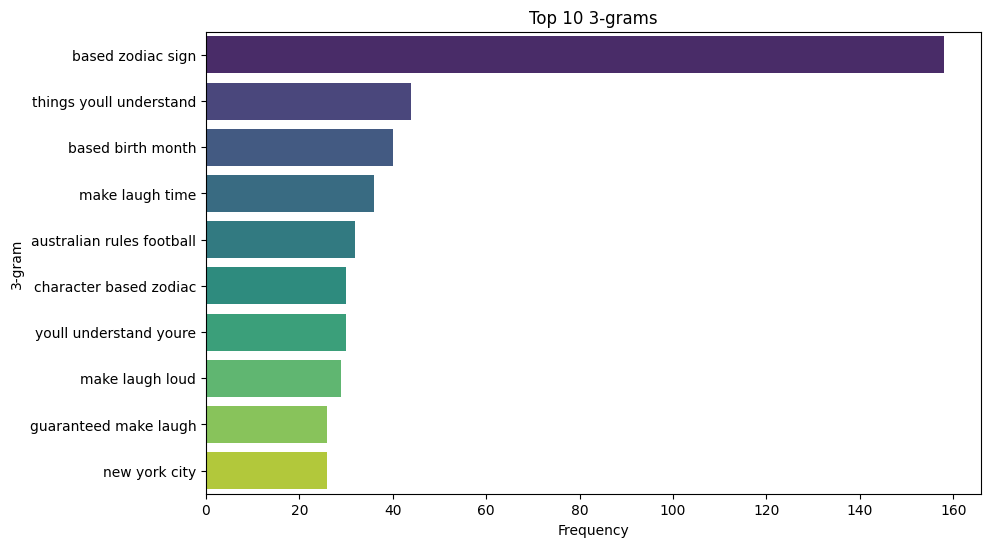

In [16]:
plot_most_frequent_ngrams(df, 'title', n=3, num_ngrams=10)

 *    Noun (NN)- Joseph, London, table, cat, teacher, pen, city

*    Verb (VB)- read, speak, run, eat, play, live, walk, have, like, are, is

*    Adjective (JJ)- beautiful, happy, sad, young, fun, three

*    Adverb (RB)- slowly, quietly, very, always, never, too, well, tomorrow

*    Preposition (IN)- at, on, in, from, with, near, between, about, under

*    Conjunction (CC)- and, or, but, because, so, yet, unless, since, if

*    Pronoun (PRP)- I, you, we, they, he, she, it, me, us, them, him, her, this

*    Interjection (INT)- Ouch! Wow! Great! Help! Oh! Hey! Hi!

# Model

## RNN

In [70]:
# train, test and validation
X_train, X_test, y_train, y_test = train_test_split(df['title'], df['label'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [72]:
# create a tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train) #tokenizer.fit_on_texts(df['title'])
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print('Vocabulary size: {}'.format(vocab_size))

# create sequences
train_sequences = tokenizer.texts_to_sequences(X_train) # list of list of int
test_sequences = tokenizer.texts_to_sequences(X_test)
val_sequences = tokenizer.texts_to_sequences(X_val)

# padding sequences
max_length = 15 # max length of each sequences
embedding_dim = 16 # dimension of the embedding vector

train_padded_sequences = pad_sequences(train_sequences, maxlen=max_length, padding='post')  # list of list of int
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_length, padding='post')  # list of list of int
val_padded_sequences = pad_sequences(val_sequences, maxlen=max_length, padding='post')  # list of list of int

Vocabulary size: 18723


In [77]:
embedding_dim = 32

from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense, Dropout
from keras.optimizers import Adam

# hyperparameters
lr = 0.001
num_epochs = 4

# Define the model
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))  # Add input_length parameter
model.add(SimpleRNN(32))
model.add(Dense(24, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Define the optimizer with the learning rate
optimizer = Adam(learning_rate=lr)

# Compile the model with the optimizer
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model
history = model.fit(train_padded_sequences, y_train, validation_data=(val_padded_sequences, y_val), epochs=num_epochs)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 15, 32)            599136    
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_16 (Dense)            (None, 24)                792       
                                                                 
 dropout_8 (Dropout)         (None, 24)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                 25        
                                                                 
Total params: 602,033
Trainable params: 602,033
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4
600/600 [=============================

In [82]:
preds = model.predict(test_padded_sequences)
preds = np.array([1 if pred > 0.5 else 0 for pred in preds])

  1/200 [..............................] - ETA: 3s

200/200 [==============================] - 0s 2ms/step


Exactitude : 0.9459375
Précision : 0.9518369867242976
Rappel : 0.9419492820042774
f1_score : 0.9468673218673219
Rapport de Classification : 
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      3127
           1       0.95      0.94      0.95      3273

    accuracy                           0.95      6400
   macro avg       0.95      0.95      0.95      6400
weighted avg       0.95      0.95      0.95      6400

Matrice de Confusion : 
Axes(0.125,0.11;0.62x0.77)


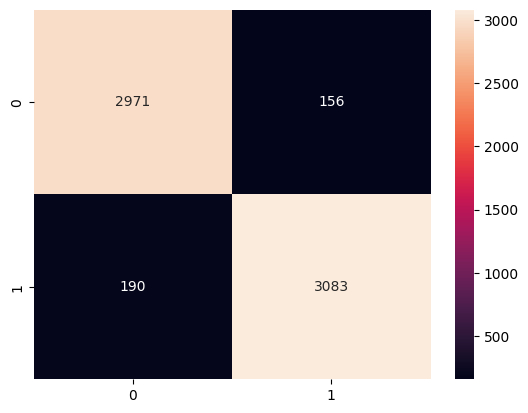

In [83]:
all_metrics(y_test, preds)

200/200 [==============================] - 0s 2ms/step


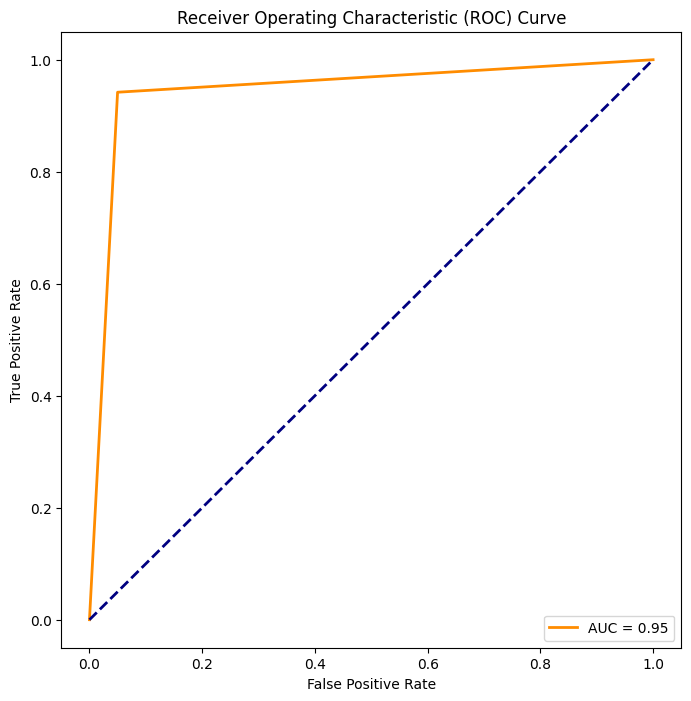

In [84]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import numpy as np

# Assuming you have a trained model named 'model' and test data (test_padded_sequences, y_test)

# Make predictions on the test set
y_pred = model.predict(test_padded_sequences)

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, preds)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## LSTM

Algorithm and methods (One-Hot encoding, TF-IDF, TF-IDF n-grams, TF-IDF char n-grams and word embeddings)

In [10]:
# train, test and validation
X_train, X_test, y_train, y_test = train_test_split(df['title'], df['label'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

#### using the embedding layer

embedding layer -> Turns positive integers (indexes) into dense vectors of fixed size.

`e.g. [[4], [20]] -> [[0.25, 0.1], [0.6, -0.2]]`


1. **Sequences** : `texts_to_sequences` prend une liste de titres des articles et convertit chaque texte en une séquence d'entiers. Chaque entier représente un mot unique dans le vocabulaire.

2. **Padding** : Les `padded_sequences` sont créées en utilisant la méthode `pad_sequences` prend les séquences créées à l'étape précédente et les remplit jusqu'à une longueur fixe. Dans ce cas, la `max_length` est fixée à 12, donc toute séquence de moins de 12 mots sera complétée par des zéros à la fin, et toute séquence de plus de 12 mots sera tronquée. 


La couche d'embedding est utilisée pour représenter les mots de manière plus significative pour le modèle. 

Voici comment cela fonctionne :

1. **Initialisation** : la couche d'embedding crée une matrice de poids où chaque ligne représente un mot du vocabulaire et chaque colonne représente une dimension de l'espace d'embedding. Les poids sont initialisés avec de petites valeurs aléatoires.

2. **Transformation des mots en vecteurs** : chaque mot est représenté par un vecteur unique dans l'espace d'embedding. 

3. **Apprentissage** : Pendant l'entraînement du modèle, les poids de la matrice d'embedding sont ajustés pour minimiser la fonction de perte. 

In [76]:
# create a tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train) #tokenizer.fit_on_texts(df['title'])
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print('Vocabulary size: {}'.format(vocab_size))

# create sequences
train_sequences = tokenizer.texts_to_sequences(X_train) # list of list of int
test_sequences = tokenizer.texts_to_sequences(X_test)
val_sequences = tokenizer.texts_to_sequences(X_val)

# padding sequences
max_length = 15 # max length of each sequences
embedding_dim = 16 # dimension of the embedding vector

train_padded_sequences = pad_sequences(train_sequences, maxlen=max_length, padding='post')  # list of list of int
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_length, padding='post')  # list of list of int
val_padded_sequences = pad_sequences(val_sequences, maxlen=max_length, padding='post')  # list of list of int

Vocabulary size: 18723


In [67]:
embedding_dim = 128

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
import tensorflow as tf
import IPython

# Define the model
def build_model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(Bidirectional(LSTM(32)))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    # Set a fixed learning rate for the Adam optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Instantiate the model
model = build_model()

# Display progress bar during training
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait=True)

# Train the model
history = model.fit(train_padded_sequences, y_train, validation_data=(val_padded_sequences, y_val), epochs=10, callbacks=[ClearTrainingOutput()])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_padded_sequences, y_test)
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))


200/200 [==============================] - 1s 6ms/step - loss: 0.2929 - accuracy: 0.9516
Test Accuracy: 95.16%


In [ ]:
model.evaluate(test_padded_sequences, y_test)

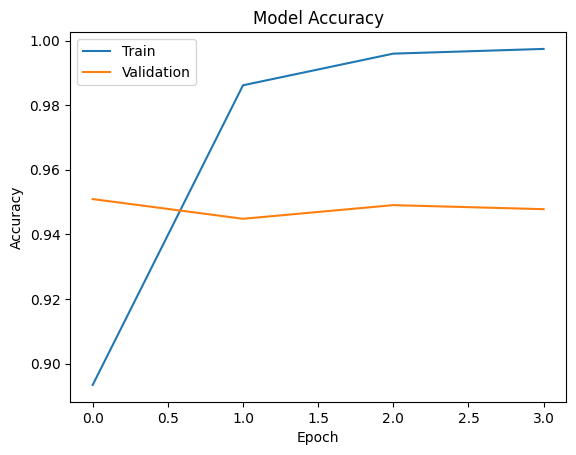

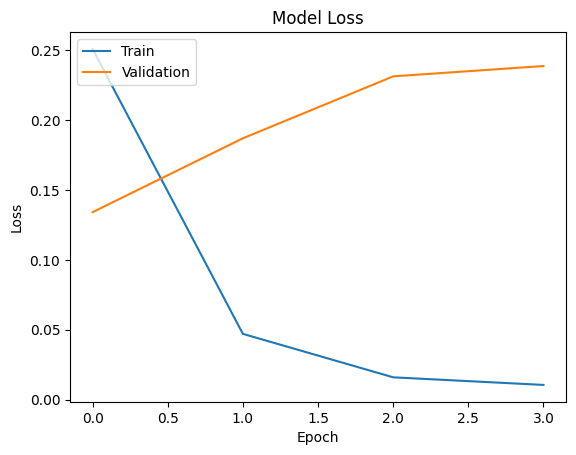

In [78]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


Exactitude : 0.95234375
Précision : 0.9527150701647346
Rappel : 0.9541704857928506
f1_score : 0.953442222561441
Rapport de Classification : 
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      3127
           1       0.95      0.95      0.95      3273

    accuracy                           0.95      6400
   macro avg       0.95      0.95      0.95      6400
weighted avg       0.95      0.95      0.95      6400

Matrice de Confusion : 
Axes(0.125,0.11;0.62x0.77)


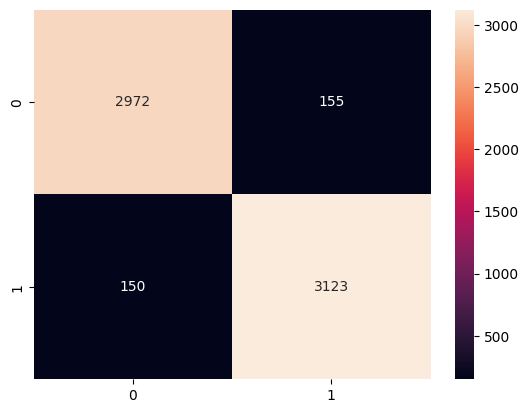

In [60]:
all_metrics(y_test, preds)

200/200 [==============================] - 2s 5ms/step


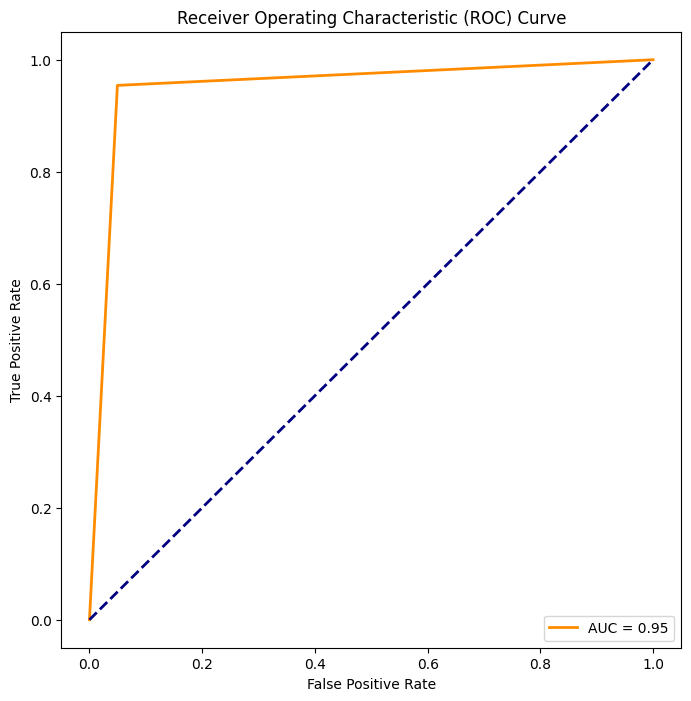

In [62]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import numpy as np

# Assuming you have a trained model named 'model' and test data (test_padded_sequences, y_test)

# Make predictions on the test set
y_pred = model.predict(test_padded_sequences)

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, preds)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

##### model architecture

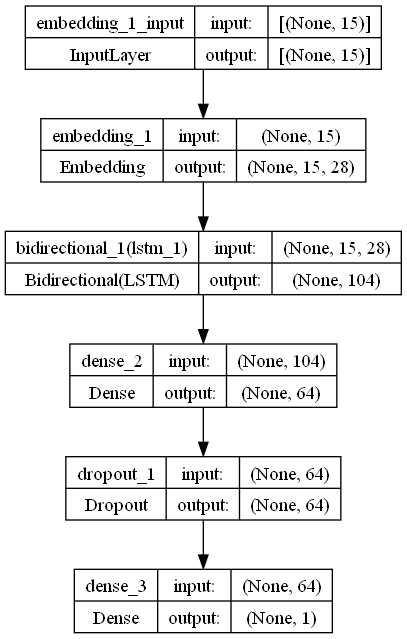

In [64]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)      

# Web application using streamlit

In [20]:
# save the model to use in the web app
model.save('model.h5')

# load the model
from tensorflow.keras.models import load_model
model = load_model('model.h5')

# save the tokenizer
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# load the tokenizer
import pickle
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)


In [35]:
# When the input changes, the cached model will be used
text = st.text_input("Enter some text", value="Classify this")
if text:
    new_title = ['issa,']
    new_sequences = tokenizer.texts_to_sequences(new_title)
    new_padded_sequences = pad_sequences(new_sequences, maxlen=max_length, padding='post')
    output = model.predict(new_padded_sequences)
    st.write("Prediction: ", output)

# show the web app using this notebook
# !streamlit run app.py

2024-01-03 17:34:10.076 
  command:

    streamlit run c:\Users\ISSAM ECH-CHAOUI\anaconda3\envs\envgpu\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


1/1 [==============================] - 1s 610ms/step
